<a href="https://colab.research.google.com/github/lukemckinstry/fastai-projects/blob/master/TweetLanguageModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TweetData

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.text import *
from fastai import *


### Google Colab Authentication

In [0]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()
drive_service = build('drive', 'v3')

In [0]:
def _create_file_request(file_id):
    return drive_service.files().get_media(fileId=file_id)


def _download_response_bytes(request, print_progress=False):
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    
    for status in _progbar(downloader):
        if print_progress:
            print("Downloaded {}/{} bytes".format(status.resumable_progress, status.total_size))
  
    downloaded.seek(0)
    return downloaded.read()

  
def _progbar(downloader):
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        yield status


def get_file_id(name):
    return get_matching_files(name)[0]['id']


def move_from_drive_to_disk(file_names, file_destinations):
    for file_name, dest in zip(file_names, file_destinations):
        file_id = get_file_id(file_name)
        print('Downloading file: "{}"'.format(file_name))
        file_bytes = _download_response_bytes(_create_file_request(file_id), print_progress=True)
        with open(dest, "wb") as f:
            f.write(file_bytes)


def load_pickled_files(file_names):
    for name in file_names:
        yield pickle.load(open(name, "rb"))
        

def get_matching_files(name):
    drive_files_response = _download_response_bytes(drive_service.files().list())
    drive_files_response_dict = json.loads(
        drive_files_response.decode('utf-8')
    )
    drive_files_dict = drive_files_response_dict['files']
  
    matching_records = [
        record
        for record in drive_files_dict
        if record['name'] == name
    ]

    no_records = len(matching_records)
    if no_records == 0:
        raise ValueError('no such file: "{}" on your Google Drive'.format(name))
    elif no_records > 1:
        print('warning: multiple matches for file "{}"'.format(name))
    return matching_records

In [5]:
train_file_name = 'tw.csv'
train_drive_file_id = get_file_id(train_file_name)

DATA_DIR = Path('/content/data/tweets/')
DATA_DIR.mkdir(exist_ok=True, parents=True)
move_from_drive_to_disk([train_file_name], [DATA_DIR/train_file_name])

Downloaded 5465487/5465487 bytes


In [7]:
!ls {DATA_DIR}

tw.csv


### Preparing Tweet Data

In [0]:
data_lm = TextLMDataBunch.from_csv(DATA_DIR, 'tw.csv', text_cols = 0)

In [0]:
data_lm.save()
#!ls {DATA_DIR}

In [0]:
data = load_data(DATA_DIR)

In [11]:
data.show_batch()

idx,text
0,of @barackobama 's xxmaj tuesday speech playing class warfare -- we paid for it with our tax dollars . xxbos xxmaj just watched former xxmaj intelligence xxmaj official xxmaj xxunk xxmaj mudd become totally xxunk and weird while debating wonderful xxup @parisdennard over xxmaj brennan ’s xxmaj security xxmaj clearance . xxmaj xxunk destroyed him but xxmaj mudd is in no mental condition to have such a xxmaj clearance .
1,"2011 xxunk \n tweetdeck , xxmaj rick xxmaj perry is right when he says we must stand by xxmaj israel in the xxup xxunk - 21 - 2011 xxunk \n tweetdeck , obamacare will destroy small business -- the backbone of xxmaj america 's xxunk - 20 - 2011 xxunk \n xxunk you 're going to think -- think big "" --- xxmaj the xxmaj art of"
2,should be investigated . ” xxmaj thank you xxmaj lou so true ! xxbos xxmaj it was my great honor to join proud hardworking xxmaj american xxmaj patriots in xxmaj montana tonight . i love you - thank you ! # xxup maga https : / / t.co / xxunk xxbos xxmaj thank you xxup xxunk ! https : / / t.co / xxunk xxbos xxmaj the only thing xxmaj
3,"xxunk \n xxmaj twitter xxmaj web xxmaj client , xxmaj last night in his xxup sotu @barackobama claimed that he is a friend of xxmaj israel . xxmaj does anyone really believe xxunk - 25 - 2012 xxunk \n twitlonger xxmaj beta , xxmaj keystone pipeline would create 2 xxrep 4 0 direct jobs another 5 xxrep 4 0 jobs xxunk the pipeline . 7 xxrep 5 0"
4,xxmaj crooked xxmaj hillary xxmaj clinton on 11 / 8 / 2016 . # xxmaj trump2016 # makeamericagreatagain https : / / t.co / xxunk xxbos .@mcilroyrory - xxmaj way to go xxmaj rory fantastic victory ! xxbos xxmaj watched chief negotiator for xxmaj iran on @charlierose last night . xxmaj he is far smarter than our reps — increase sanctions and walk ! xxbos xxmaj looking forward to xxup


## Load Learner, Find LR

We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

In [0]:
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.3)

In [13]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


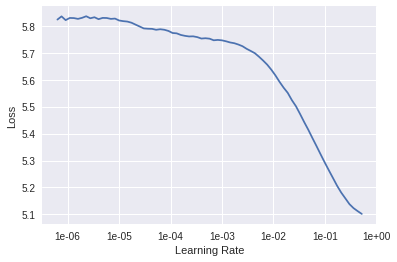

In [14]:
learn.recorder.plot(skip_end=15)

In [15]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,3.526693,3.174456,0.426614,01:24


In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [0]:
learn.unfreeze()

In [19]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,3.143641,3.049137,0.443274,01:43
2,3.025429,2.923505,0.458607,01:43
3,2.844923,2.829860,0.468596,01:43
4,2.665311,2.769883,0.475352,01:43
5,2.515930,2.744600,0.478902,01:43
6,2.407990,2.734642,0.480422,01:43
7,2.266559,2.740205,0.482293,01:43
8,2.166686,2.747100,0.482546,01:43
9,2.116822,2.756106,0.482413,01:43
10,2.049948,2.761451,0.481997,01:43


In [0]:
learn.save('fine_tuned')

In [22]:
!ls {DATA_DIR}/'models'

fine_tuned.pth	fit_head.pth  tmp.pth


How good is our model? Well let's try to see what it predicts after a few given words.

In [0]:
learn.load('fine_tuned');

In [0]:
TEXT = "iran deal"
N_WORDS = 40
N_SENTENCES = 2

In [29]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

iran deal with Russia was a very bad idea . xxbos RT @foxandfriends : The Time for Growth ' # Florence # UNGA https : / / t.co / google xxbos Just out on
iran deal was a disaster . Thank you to President Trump for the nice words on @foxandfriends . xxbos The U.S. needs to get tough again . We need a tough A.G. who is running


We not only have to save the model, but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [0]:
learn.save_encoder('fine_tuned_enc')